In [ ]:
!pip install transformers av librosa torchsummary huggingface_hub

# Import necessary libraries
import json
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import av
import numpy as np
import librosa
import matplotlib.pyplot as plt
from transformers import EncodecModel, AutoProcessor, VivitModel, VivitImageProcessor
from huggingface_hub import hf_hub_download
from torchsummary import summary  # For parameters summary, but we'll implement manually
import torch.nn.functional as F
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the JSON data
json_path = "/content/drive/MyDrive/IE_643_Project/train_5000.json"
with open(json_path, "r") as f:
    data = json.load(f)
print(f"Loaded {len(data)} video-audio pairs.")



Using device: cuda
Loaded 5000 video-audio pairs.


In [ ]:
encodec = EncodecModel.from_pretrained("facebook/encodec_24khz").to(device)
audio_processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

# Freeze the entire audio encoder
for param in encodec.parameters():
    param.requires_grad = False

# Load ViViT model and image processor (video encoder)
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400").to(device)
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400", use_fast=True)

# Freeze all layers in ViViT except the 11th layer (index 10, since 0-based)
for param in model.parameters():
    param.requires_grad = False
for name, param in model.named_parameters():
    if "encoder.layer.11" in name:  # 11th layer (0 to 11, 11th is index 10)
        param.requires_grad = True

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/93.1M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # CNN layers with avg pooling and dropout
        self.conv1 = nn.Conv1d(768, 512, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout after conv1
        self.conv2 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.3)  # Dropout after conv2
        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(p=0.3)  # Dropout after conv3

        # ANN layers (pointwise convolutions for per-position fully connected)
        self.fc1 = nn.Conv1d(128, 256, kernel_size=1)
        self.dropout_fc1 = nn.Dropout(p=0.3)  # Dropout after fc1
        self.fc2 = nn.Conv1d(256, 128, kernel_size=1)

        # Adaptive pooling to exactly 750 length
        self.adaptive_pool = nn.AdaptiveAvgPool1d(750)

    def forward(self, x):
        # x: (batch, 3137, 768)
        # Drop last row (class token)
        x = x[:, :-1, :]  # (batch, 3136, 768)
        # Transpose for Conv1d: channels first
        x = x.transpose(1, 2)  # (batch, 768, 3136)

        # CNN part
        x = F.relu(self.conv1(x))  # (batch, 512, 3136)
        x = self.dropout1(x)  # Apply dropout
        x = self.pool1(x)  # (batch, 512, 1568)
        x = F.relu(self.conv2(x))  # (batch, 256, 1568)
        x = self.dropout2(x)  # Apply dropout
        x = self.pool2(x)  # (batch, 256, 784)
        x = F.relu(self.conv3(x))  # (batch, 128, 784)
        x = self.dropout3(x)  # Apply dropout

        # ANN part
        x = F.relu(self.fc1(x))  # (batch, 256, 784)
        x = self.dropout_fc1(x)  # Apply dropout
        x = self.fc2(x)  # (batch, 128, 784)

        # Adaptive pool to reduce length to 750
        x = self.adaptive_pool(x)  # (batch, 128, 750)

        # Transpose back to (batch, seq, feat)
        x = x.transpose(1, 2)  # (batch, 750, 128)
        return x

# Usage example
input_tensor = torch.randn(5, 3137, 768)  # Your input tensor
network = Network()
network.train()  # Ensure dropout is active during training
video_fcc = network(input_tensor).to(device)
 # torch.Size([5, 750, 128])

trainable_params =  list(network.parameters()) + \
                   [p for p in model.parameters() if p.requires_grad]

# Print parameters summary
print("Trainable Parameters Summary:")
total_params = 0
print("ViViT Trainable Layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        num = param.numel()
        print(f"{name}: {num}")
        total_params += num
# print("\nAudio FCC:")
# for name, param in audio_fcc.named_parameters():
#     num = param.numel()
#     print(f"{name}: {num}")
#     total_params += num
print("\nVideo FCC:")
for name, param in network.named_parameters():
    num = param.numel()
    print(f"{name}: {num}")
    total_params += num
print(f"\nTotal Trainable Parameters: {total_params}")

Trainable Parameters Summary:
ViViT Trainable Layers:
encoder.layer.11.attention.attention.query.weight: 589824
encoder.layer.11.attention.attention.query.bias: 768
encoder.layer.11.attention.attention.key.weight: 589824
encoder.layer.11.attention.attention.key.bias: 768
encoder.layer.11.attention.attention.value.weight: 589824
encoder.layer.11.attention.attention.value.bias: 768
encoder.layer.11.attention.output.dense.weight: 589824
encoder.layer.11.attention.output.dense.bias: 768
encoder.layer.11.intermediate.dense.weight: 2359296
encoder.layer.11.intermediate.dense.bias: 3072
encoder.layer.11.output.dense.weight: 2359296
encoder.layer.11.output.dense.bias: 768
encoder.layer.11.layernorm_before.weight: 768
encoder.layer.11.layernorm_before.bias: 768
encoder.layer.11.layernorm_after.weight: 768
encoder.layer.11.layernorm_after.bias: 768

Video FCC:
conv1.weight: 1179648
conv1.bias: 512
conv2.weight: 393216
conv2.bias: 256
conv3.weight: 98304
conv3.bias: 128
fc1.weight: 32768
fc1.bias

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Network(nn.Module):
    """
    Very small video encoder
    Input  : (B, 3137, 768)   →  drop class token → (B, 3136, 768)
    Output : (B, 750 , 128)
    """
    def __init__(self, dropout=0.3):
        super().__init__()

        # 1) One Conv1d + AvgPool to shrink the length
        self.conv   = nn.Conv1d(768, 256, kernel_size=3, padding=1)   # → (B,256,3136)
        self.pool   = nn.AvgPool1d(kernel_size=4, stride=4)          # → (B,256,784)
        self.drop1  = nn.Dropout(p=dropout)

        # 2) Point-wise conv to bring channels to 128
        self.fc     = nn.Conv1d(256, 128, kernel_size=1)             # → (B,128,784)

        # 3) Adaptive pooling to exactly 750 time-steps
        self.adapt  = nn.AdaptiveAvgPool1d(750)                      # → (B,128,750)

    def forward(self, x):
        # x : (B, 3137, 768)
        x = x[:, :-1, :]                 # drop class token → (B,3136,768)
        x = x.transpose(1, 2)            # Conv1d expects (B,C,L) → (B,768,3136)

        x = F.relu(self.conv(x))         # (B,256,3136)
        x = self.drop1(x)
        x = self.pool(x)                 # (B,256,784)

        x = F.relu(self.fc(x))           # (B,128,784)
        x = self.adapt(x)                # (B,128,750)

        x = x.transpose(1, 2)            # back to (B,750,128)
        return x*50

# Usage example
input_tensor = torch.randn(5, 3137, 768)  # Your input tensor
network = Network()
network.train()  # Ensure dropout is active during training
video_fcc = network(input_tensor).to(device)
 # torch.Size([5, 750, 128])

trainable_params =  list(network.parameters()) + \
                   [p for p in model.parameters() if p.requires_grad]

# Print parameters summary
print("Trainable Parameters Summary:")
total_params = 0
print("ViViT Trainable Layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        num = param.numel()
        print(f"{name}: {num}")
        total_params += num
# print("\nAudio FCC:")
# for name, param in audio_fcc.named_parameters():
#     num = param.numel()
#     print(f"{name}: {num}")
#     total_params += num
print("\nVideo FCC:")
for name, param in network.named_parameters():
    num = param.numel()
    print(f"{name}: {num}")
    total_params += num
print(f"\nTotal Trainable Parameters: {total_params}")

Trainable Parameters Summary:
ViViT Trainable Layers:
encoder.layer.11.attention.attention.query.weight: 589824
encoder.layer.11.attention.attention.query.bias: 768
encoder.layer.11.attention.attention.key.weight: 589824
encoder.layer.11.attention.attention.key.bias: 768
encoder.layer.11.attention.attention.value.weight: 589824
encoder.layer.11.attention.attention.value.bias: 768
encoder.layer.11.attention.output.dense.weight: 589824
encoder.layer.11.attention.output.dense.bias: 768
encoder.layer.11.intermediate.dense.weight: 2359296
encoder.layer.11.intermediate.dense.bias: 3072
encoder.layer.11.output.dense.weight: 2359296
encoder.layer.11.output.dense.bias: 768
encoder.layer.11.layernorm_before.weight: 768
encoder.layer.11.layernorm_before.bias: 768
encoder.layer.11.layernorm_after.weight: 768
encoder.layer.11.layernorm_after.bias: 768

Video FCC:
conv.weight: 589824
conv.bias: 256
fc.weight: 32768
fc.bias: 128

Total Trainable Parameters: 7710848


In [ ]:
import cv2
# Optimizer
optimizer = optim.Adam(trainable_params, lr=1e-4)

np.random.seed(0)

def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index   = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame.to_ndarray(format="rgb24"))
    # Now frames is list of arrays shape (H, W, 3)
    return np.stack(frames)  # shape (num_frames, H, W, 3)

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    if seg_len <= converted_len:
        # fallback: sample from [0, seg_len)
        indices = np.linspace(0, seg_len - 1, num=clip_len).astype(int)
    else:
        end_idx  = np.random.randint(converted_len, seg_len)
        start_idx= end_idx - converted_len
        indices  = np.linspace(start_idx, end_idx, num=clip_len)
        indices  = np.clip(indices, start_idx, end_idx - 1).astype(int)
    return indices
def ensure_fixed_frames(video_array, target_len=32):
    """Resample or pad video to fixed number of frames."""
    num_frames = video_array.shape[0]
    if num_frames == target_len:
        return video_array
    indices = np.linspace(0, num_frames - 1, target_len).astype(int)
    return video_array[indices]
def center_crop_frames(video_array, crop_size=224):
    # video_array: (T, H, W, 3)
    T, H, W, _ = video_array.shape
    y1 = (H - crop_size) // 2
    x1 = (W - crop_size) // 2
    return video_array[:, y1:y1+crop_size, x1:x1+crop_size, :]


In [ ]:
def ensure_fixed_frames(video_array, target_len=32):
    """Resample or pad video to fixed number of frames with zeros if needed."""
    num_frames = video_array.shape[0]
    if num_frames == target_len:
        return video_array
    elif num_frames > target_len:
        # Subsample frames if too many
        indices = np.linspace(0, num_frames - 1, target_len).astype(int)
        return video_array[indices]
    else:
        # Pad with zero-filled frames if too few
        padding_frames = target_len - num_frames
        # Create zero-filled array with same spatial dimensions and channels
        zero_pad = np.zeros((padding_frames, *video_array.shape[1:]), dtype=video_array.dtype)
        # Concatenate original frames with padding
        return np.concatenate([video_array, zero_pad], axis=0)

In [ ]:

# def ensure_fixed_frames(video_array, target_len=32):
#     """Resample or pad video to fixed number of frames with zeros if needed."""
#     num_frames = video_array.shape[0]
#     if num_frames == target_len:
#         return video_array
#     elif num_frames > target_len:
#         # Subsample frames if too many
#         indices = np.linspace(0, num_frames - 1, target_len).astype(int)
#         return video_array[indices]
#     else:
#         # Pad with zero-filled frames if too few
#         padding_frames = target_len - num_frames
#         # Create zero-filled array with same spatial dimensions and channels
#         zero_pad = np.zeros((padding_frames, *video_array.shape[1:]), dtype=video_array.dtype)
#         # Concatenate original frames with padding
#         return np.concatenate([video_array, zero_pad], axis=0)
def compute_metrics(M1, M2):
    """
    Compute Frobenius norm of ||M1 - M2|| and MSE-like metric ||M1 - M2|| / ||M1||.

    Args:
        M1 (torch.Tensor): Tensor of shape (batch_size, 750, 128)
        M2 (torch.Tensor): Tensor of shape (batch_size, 750, 128)

    Returns:
        frobenius_norm (torch.Tensor): Shape (batch_size,) with ||M1 - M2|| for each batch
        mse_like (torch.Tensor): Shape (batch_size,) with ||M1 - M2|| / ||M1||
    """
    # Ensure shapes match
    assert M1.shape == M2.shape, "M1 and M2 must have the same shape"
    assert M1.shape[1:] == (750, 128), "Expected shape (batch_size, 750, 128)"

    # Compute difference: M1 - M2
    diff = M1 - M2  # Shape: (batch_size, 750, 128)

    # Frobenius norm of difference: sqrt(sum((M1 - M2)^2))
    frobenius_norm = torch.sqrt(torch.sum(diff ** 2, dim=(1, 2)))  # Shape: (batch_size,)

    # Frobenius norm of M1: sqrt(sum(M1^2))
    norm_M1 = torch.sqrt(torch.sum(M1 ** 2, dim=(1, 2)))  # Shape: (batch_size,)

    # MSE-like metric: ||M1 - M2|| / ||M1||
    mse_like = frobenius_norm / norm_M1  # Shape: (batch_size,)

    return frobenius_norm, mse_like
# M1 = torch.randn(5, 750, 128)
# M2 = torch.randn(5, 750, 128)  # e.g., codegram or reference tensor
# frobenius_norm, mse_like = compute_metrics(M1, M2)
# print("Frobenius Norm:", frobenius_norm.mean(dim=0))
# print("MSE-like Metric:", mse_like.mean(dim=0))
# 0.6*frobenius_norm.mean(dim=0)


==================== Epoch 1/20 ====================


Batches:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `VivitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Batches:   5%|▌         | 1/20 [00:02<00:48,  2.57s/it]


First batch gradient check:
  network.conv.weight: 6.28851175
  network.fc.weight: 2.16354513
  encoder.layer.11.attention.attention.value.weight: 0.38651007
  encoder.layer.11.attention.output.dense.weight: 0.33295947
  encoder.layer.11.intermediate.dense.weight: 0.27222809
  encoder.layer.11.output.dense.weight: 0.26341346
  encoder.layer.11.attention.attention.key.weight: 0.21617517
  network.fc.bias: 0.20180851
  encoder.layer.11.attention.attention.query.weight: 0.16414081
  network.conv.bias: 0.10671220

Similarity matrix (first batch):
[[-0.72355103 -1.0798448  -0.26860708 -0.7649549  -1.7217336 ]
 [-0.8236799  -1.139658   -0.3508613  -0.85268056 -1.8250747 ]
 [-0.6793427  -1.0386823  -0.22182395 -0.7006966  -1.685053  ]
 [-0.7588705  -1.0983808  -0.31087583 -0.7888801  -1.7685183 ]
 [-0.88614345 -1.1834666  -0.41595775 -0.93478113 -1.8946515 ]]


Batches: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Pos: -0.773 | Neg: -0.809
Epoch 1/20 | Loss: 1.595653 | GradNorm: 0.963866 | LR: 3.00e-04

==================== Epoch 2/20 ====================


Batches: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Pos: -0.322 | Neg: -0.634
Epoch 2/20 | Loss: 1.436831 | GradNorm: 0.706474 | LR: 3.00e-04

==================== Epoch 3/20 ====================


Batches: 100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


Pos: -0.214 | Neg: -0.636
Epoch 3/20 | Loss: 1.361336 | GradNorm: 0.965575 | LR: 3.00e-04

==================== Epoch 4/20 ====================


Batches: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Pos: -0.102 | Neg: -0.402
Epoch 4/20 | Loss: 1.363040 | GradNorm: 2.232220 | LR: 3.00e-04

==================== Epoch 5/20 ====================


Batches: 100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


Pos: 0.245 | Neg: -0.363
Epoch 5/20 | Loss: 1.365870 | GradNorm: 0.252470 | LR: 3.00e-04

==================== Epoch 6/20 ====================


Batches: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


Pos: 0.103 | Neg: -0.455
Epoch 6/20 | Loss: 1.398032 | GradNorm: 0.805036 | LR: 3.00e-04

==================== Epoch 7/20 ====================


Batches: 100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Pos: 0.266 | Neg: -0.293
Epoch 7/20 | Loss: 1.351728 | GradNorm: 0.154985 | LR: 3.00e-04

==================== Epoch 8/20 ====================


Batches: 100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


Pos: 0.376 | Neg: -0.250
Epoch 8/20 | Loss: 1.344092 | GradNorm: 0.337065 | LR: 3.00e-04

==================== Epoch 9/20 ====================


Batches: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Pos: 0.355 | Neg: -0.303
Epoch 9/20 | Loss: 1.325626 | GradNorm: 0.355160 | LR: 3.00e-04

==================== Epoch 10/20 ====================


Batches: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


Pos: 0.288 | Neg: -0.298
Epoch 10/20 | Loss: 1.329187 | GradNorm: 0.771074 | LR: 3.00e-04

==================== Epoch 11/20 ====================


Batches: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Pos: 0.360 | Neg: -0.300
Epoch 11/20 | Loss: 1.322151 | GradNorm: 0.202703 | LR: 3.00e-05

==================== Epoch 12/20 ====================


Batches: 100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


Pos: 0.314 | Neg: -0.316
Epoch 12/20 | Loss: 1.313112 | GradNorm: 1.073078 | LR: 3.00e-05

==================== Epoch 13/20 ====================


Batches: 100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


Pos: 0.330 | Neg: -0.316
Epoch 13/20 | Loss: 1.314282 | GradNorm: 0.451861 | LR: 3.00e-05

==================== Epoch 14/20 ====================


Batches: 100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Pos: 0.371 | Neg: -0.289
Epoch 14/20 | Loss: 1.307169 | GradNorm: 0.424734 | LR: 3.00e-05

==================== Epoch 15/20 ====================


Batches: 100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


Pos: 0.363 | Neg: -0.293
Epoch 15/20 | Loss: 1.303747 | GradNorm: 0.514905 | LR: 3.00e-05

==================== Epoch 16/20 ====================


Batches: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Pos: 0.346 | Neg: -0.306
Epoch 16/20 | Loss: 1.307148 | GradNorm: 0.478643 | LR: 3.00e-05

==================== Epoch 17/20 ====================


Batches: 100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


Pos: 0.307 | Neg: -0.324
Epoch 17/20 | Loss: 1.301537 | GradNorm: 0.482762 | LR: 3.00e-05

==================== Epoch 18/20 ====================


Batches: 100%|██████████| 20/20 [00:50<00:00,  2.50s/it]


Pos: 0.383 | Neg: -0.282
Epoch 18/20 | Loss: 1.301916 | GradNorm: 0.438759 | LR: 3.00e-05

==================== Epoch 19/20 ====================


Batches: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


Pos: 0.360 | Neg: -0.295
Epoch 19/20 | Loss: 1.301979 | GradNorm: 0.344722 | LR: 3.00e-05

==================== Epoch 20/20 ====================


Batches: 100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


Pos: 0.347 | Neg: -0.304
Epoch 20/20 | Loss: 1.300173 | GradNorm: 0.414666 | LR: 3.00e-05


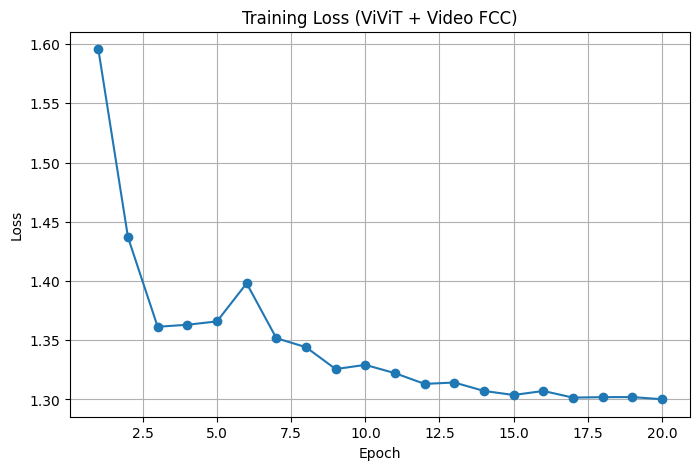

In [ ]:
# --------------------------------------------------------------
#  Hyper-parameters (unchanged)
# --------------------------------------------------------------
from itertools import chain
import torch.optim.lr_scheduler as lr_scheduler
num_epochs   = 20
batch_size   = 5
max_duration = 10          # seconds
sr           = 24000
tau          = 0.07
lam1         = 1.0
lam2         = 0.0
selected_pairs = data[:100]

# --------------------------------------------------------------
#  ViViT – we will fine-tune only the *last* transformer blocks
# --------------------------------------------------------------
# # Freeze everything first
# for p in model.parameters():
#     p.requires_grad = False

# # Un-freeze the last N transformer layers (e.g. last 4 layers)
# num_layers_to_unfreeze = 4
# for i, layer in enumerate(model.encoder.layers[-num_layers_to_unfreeze:]):
#     for p in layer.parameters():
#         p.requires_grad = True

# --------------------------------------------------------------
#  Video FCC (your custom head)
# --------------------------------------------------------------
network = Network().to(device)          # <-- your class from the previous cell
network.train()

# --------------------------------------------------------------
#  Trainable parameters = ViViT (unfrozen) + Network
# --------------------------------------------------------------
trainable_params = [
    p for p in chain(model.parameters(), network.parameters())
    if p.requires_grad
]

# --------------------------------------------------------------
#  Optimizer & Scheduler
# --------------------------------------------------------------
optimizer = optim.Adam(trainable_params, lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
losses = []
similarity_matrix_printed = False

for epoch in range(num_epochs):
    num_batches = len(selected_pairs) // batch_size
    epoch_loss  = 0.0
    print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}")

    for batch_idx in tqdm(range(num_batches), desc="Batches"):
        batch = selected_pairs[batch_idx*batch_size : (batch_idx+1)*batch_size]

        # ------------------- AUDIO (EnCodec – frozen) -------------------
        wavs = []
        for item in batch:
            wav, _ = librosa.load(item["audio_path"], sr=sr, mono=True)
            target_len = sr * max_duration
            if len(wav) > target_len:
                wav = wav[:target_len]
            else:
                wav = np.pad(wav, (0, target_len - len(wav)), "constant")
            wavs.append(wav)

        audio_inputs = audio_processor(raw_audio=wavs,
                                       sampling_rate=sr,
                                       return_tensors="pt")
        input_values = audio_inputs["input_values"].to(device)

        # EnCodec encoder (no grad)
        with torch.no_grad():
            encoder_output = encodec.encoder(input_values).permute(0, 2, 1)   # (B, C, T)
        audio_feats = encoder_output.reshape(5,-1)
        audio_proj  = audio_feats / torch.norm(audio_feats, dim=1, keepdim=True).clamp(min=1e-6)

        # ------------------- VIDEO (ViViT – trainable) -------------------
        videos = []
        for item in batch:
            container = av.open(item["video_path"])
            seg_len   = container.streams.video[0].frames
            idx       = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
            vid       = read_video_pyav(container, idx)
            vid       = ensure_fixed_frames(vid, 32)
            vid       = center_crop_frames(vid, crop_size=224)
            videos.append(vid.astype(np.uint8))

        videos_as_lists = [[f for f in v] for v in videos]
        inputs = image_processor(videos_as_lists,
                                 return_tensors="pt",
                                 data_format="channels_first",
                                 padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # *** ViViT forward – gradients flow ***
        outputs          = model(**inputs)                 # <-- NO torch.no_grad()
        last_hidden_states = outputs.last_hidden_state     # (B, 3137, 768)

        # ------------------- Video FCC (trainable) -------------------
        video_fcc = network(last_hidden_states)            # (B, 750, 128)
        video_proj = video_fcc.reshape(5,-1)
        video_proj = video_proj / torch.norm(video_proj, dim=1, keepdim=True).clamp(min=1e-6)

        # ------------------- Contrastive Loss -------------------
        sim = (audio_proj @ video_proj.T) / tau
        labels = torch.arange(batch_size, device=device)
        logits = sim
        # loss_a2v = -F.log_softmax(sim, dim=1)[torch.arange(batch_size), labels].mean()
        # loss_v2a = -F.log_softmax(sim.T, dim=1)[torch.arange(batch_size), labels].mean()
        # loss1 = (loss_a2v + loss_v2a) / 2
        loss_a2v = F.cross_entropy(logits, labels)
        loss_v2a = F.cross_entropy(logits.T, labels)
        loss1 = (loss_a2v + loss_v2a) / 2

        # ------------------- Optional MSE loss -------------------
        _, mse_like = compute_metrics(encoder_output, video_fcc)
        loss2 = mse_like.mean(dim=0)

        loss = lam1 * loss1 + lam2 * loss2
        epoch_loss += loss.item()

        # ------------------- BACK-PROP -------------------
        optimizer.zero_grad()          # <-- **CRUCIAL**
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        optimizer.step()
        if batch_idx == 0 and epoch == 0:
          print("\nFirst batch gradient check:")
          grad_norms = {}
          for name, p in model.named_parameters():
              if p.requires_grad and p.grad is not None:
                  grad_norms[name] = p.grad.norm().item()
          for name, p in network.named_parameters():
              if p.grad is not None:
                  grad_norms[f"network.{name}"] = p.grad.norm().item()

          if grad_norms:
              for k, v in sorted(grad_norms.items(), key=lambda x: -x[1])[:10]:
                  print(f"  {k}: {v:.8f}")
          else:
              print("  NO GRADIENTS FOUND ANYWHERE!")
        # ---- Print similarity matrix once ----
        if epoch == 0 and batch_idx == 0 and not similarity_matrix_printed:
            print("\nSimilarity matrix (first batch):")
            print(sim.detach().cpu().numpy())
            similarity_matrix_printed = True

    # ------------------- Epoch Summary -------------------
    avg_loss = epoch_loss / num_batches
    print(f"Pos: {torch.diag(sim).mean():.3f} | Neg: {sim.fill_diagonal_(0).mean():.3f}")
    # Gradient norm (L2) over *all* trainable params
    total_norm = 0.0
    for p in trainable_params:
        if p.grad is not None:
            total_norm += p.grad.detach().data.norm(2).item() ** 2
    total_norm = total_norm ** 0.5

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Loss: {avg_loss:.6f} | "
          f"GradNorm: {total_norm:.6f} | "
          f"LR: {scheduler.get_last_lr()[0]:.2e}")

    losses.append(avg_loss)
    scheduler.step()

# --------------------------------------------------------------
#  Plot loss curve
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (ViViT + Video FCC)')
plt.grid(True)
plt.show()

Using device: cuda

==================== Epoch 1/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]


Similarity matrix (global average):
[[ 1.363 -2.219 -0.262 -1.898  0.528  0.734  0.081  0.844  0.49  -1.024
  -0.538  2.79  -0.918 -1.298 -0.306  1.931]
 [-0.112  0.82  -2.787 -0.226 -3.016  2.973  0.406  1.427 -1.677  1.523
  -0.284  0.071 -0.703  1.129 -0.162 -0.076]
 [-0.217  1.188  1.062  0.927  0.182 -0.46  -1.036  2.006  0.252 -0.422
  -0.609  0.621  0.228 -2.432 -1.207 -0.623]
 [-0.377  0.409 -0.507  0.416  0.852 -0.623 -0.65  -1.235  0.404  1.907
   0.418  0.728  1.02  -1.707  0.518 -1.646]
 [ 0.252  3.18  -1.393  0.115  0.306 -0.102  1.187 -1.998  0.251 -0.678
  -1.52  -1.304  0.922  2.74  -1.724 -1.324]
 [ 1.646 -1.563 -0.459  0.951  1.245  0.84  -1.723  0.09   0.953  1.637
   1.456 -1.729 -1.078 -1.71   0.959 -0.664]
 [-0.892 -2.062  1.485  0.6   -0.967 -0.998  0.045  1.15   1.362 -0.988
   0.578  0.218 -0.244  1.923 -0.578 -0.372]
 [ 0.025  1.018  0.202 -0.448  0.996  0.88  -1.484  1.705 -0.39  -2.057
   2.766 -2.336  0.692 -0.313 -1.813  0.308]
 [ 0.974 -0.906  0.68   0.7

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 1.021 | Neg: -0.065 | τ: 0.070
Epoch 2/45 | Loss: 2.921930 | GradNorm: 1.000 | LR: 2.00e-04

==================== Epoch 3/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 2.785 | Neg: -0.169 | τ: 0.070
Epoch 3/45 | Loss: 1.881806 | GradNorm: 1.000 | LR: 3.00e-04

==================== Epoch 4/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 3.828 | Neg: -0.243 | τ: 0.070
Epoch 4/45 | Loss: 1.132274 | GradNorm: 1.000 | LR: 3.00e-04

==================== Epoch 5/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.203 | Neg: -0.261 | τ: 0.070
Epoch 5/45 | Loss: 0.872206 | GradNorm: 1.000 | LR: 2.98e-04

==================== Epoch 6/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.742 | Neg: -0.297 | τ: 0.070
Epoch 6/45 | Loss: 0.799479 | GradNorm: 1.000 | LR: 2.96e-04

==================== Epoch 7/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.680 | Neg: -0.293 | τ: 0.070
Epoch 7/45 | Loss: 0.795217 | GradNorm: 1.000 | LR: 2.93e-04

==================== Epoch 8/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.703 | Neg: -0.355 | τ: 0.070
Epoch 8/45 | Loss: 0.762462 | GradNorm: 1.000 | LR: 2.90e-04

==================== Epoch 9/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.949 | Neg: -0.308 | τ: 0.070
Epoch 9/45 | Loss: 0.755833 | GradNorm: 1.000 | LR: 2.85e-04

==================== Epoch 10/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.203 | Neg: -0.320 | τ: 0.070
Epoch 10/45 | Loss: 0.758656 | GradNorm: 1.000 | LR: 2.80e-04

==================== Epoch 11/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.398 | Neg: -0.335 | τ: 0.070
Epoch 11/45 | Loss: 0.729856 | GradNorm: 1.000 | LR: 2.74e-04

==================== Epoch 12/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.750 | Neg: -0.357 | τ: 0.070
Epoch 12/45 | Loss: 0.731054 | GradNorm: 1.000 | LR: 2.67e-04

==================== Epoch 13/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.254 | Neg: -0.330 | τ: 0.070
Epoch 13/45 | Loss: 0.724789 | GradNorm: 1.000 | LR: 2.60e-04

==================== Epoch 14/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.152 | Neg: -0.313 | τ: 0.070
Epoch 14/45 | Loss: 0.715529 | GradNorm: 1.000 | LR: 2.52e-04

==================== Epoch 15/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.938 | Neg: -0.369 | τ: 0.070
Epoch 15/45 | Loss: 0.714029 | GradNorm: 1.000 | LR: 2.44e-04

==================== Epoch 16/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.418 | Neg: -0.340 | τ: 0.070
Epoch 16/45 | Loss: 0.705756 | GradNorm: 1.000 | LR: 2.34e-04

==================== Epoch 17/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.184 | Neg: -0.320 | τ: 0.070
Epoch 17/45 | Loss: 0.696412 | GradNorm: 1.000 | LR: 2.25e-04

==================== Epoch 18/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.754 | Neg: -0.360 | τ: 0.070
Epoch 18/45 | Loss: 0.678336 | GradNorm: 1.000 | LR: 2.15e-04

==================== Epoch 19/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.031 | Neg: -0.306 | τ: 0.070
Epoch 19/45 | Loss: 0.683116 | GradNorm: 1.000 | LR: 2.05e-04

==================== Epoch 20/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.195 | Neg: -0.322 | τ: 0.070
Epoch 20/45 | Loss: 0.673079 | GradNorm: 1.000 | LR: 1.94e-04

==================== Epoch 21/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.422 | Neg: -0.342 | τ: 0.070
Epoch 21/45 | Loss: 0.668851 | GradNorm: 1.000 | LR: 1.83e-04

==================== Epoch 22/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.320 | Neg: -0.327 | τ: 0.070
Epoch 22/45 | Loss: 0.666868 | GradNorm: 1.000 | LR: 1.72e-04

==================== Epoch 23/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.570 | Neg: -0.347 | τ: 0.070
Epoch 23/45 | Loss: 0.656062 | GradNorm: 1.000 | LR: 1.61e-04

==================== Epoch 24/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.289 | Neg: -0.325 | τ: 0.070
Epoch 24/45 | Loss: 0.656450 | GradNorm: 1.000 | LR: 1.50e-04

==================== Epoch 25/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.242 | Neg: -0.327 | τ: 0.070
Epoch 25/45 | Loss: 0.653941 | GradNorm: 1.000 | LR: 1.39e-04

==================== Epoch 26/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.203 | Neg: -0.326 | τ: 0.070
Epoch 26/45 | Loss: 0.645859 | GradNorm: 1.000 | LR: 1.28e-04

==================== Epoch 27/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.902 | Neg: -0.308 | τ: 0.070
Epoch 27/45 | Loss: 0.641799 | GradNorm: 1.000 | LR: 1.17e-04

==================== Epoch 28/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.223 | Neg: -0.319 | τ: 0.070
Epoch 28/45 | Loss: 0.642162 | GradNorm: 0.912 | LR: 1.06e-04

==================== Epoch 29/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.062 | Neg: -0.312 | τ: 0.070
Epoch 29/45 | Loss: 0.634584 | GradNorm: 1.000 | LR: 9.52e-05

==================== Epoch 30/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.887 | Neg: -0.301 | τ: 0.070
Epoch 30/45 | Loss: 0.633242 | GradNorm: 1.000 | LR: 8.49e-05

==================== Epoch 31/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.035 | Neg: -0.311 | τ: 0.070
Epoch 31/45 | Loss: 0.632082 | GradNorm: 1.000 | LR: 7.50e-05

==================== Epoch 32/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.047 | Neg: -0.312 | τ: 0.070
Epoch 32/45 | Loss: 0.632582 | GradNorm: 1.000 | LR: 6.55e-05

==================== Epoch 33/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.199 | Neg: -0.324 | τ: 0.070
Epoch 33/45 | Loss: 0.627757 | GradNorm: 0.792 | LR: 5.65e-05

==================== Epoch 34/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.199 | Neg: -0.321 | τ: 0.070
Epoch 34/45 | Loss: 0.624499 | GradNorm: 1.000 | LR: 4.80e-05

==================== Epoch 35/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.965 | Neg: -0.310 | τ: 0.070
Epoch 35/45 | Loss: 0.624345 | GradNorm: 1.000 | LR: 4.00e-05

==================== Epoch 36/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.223 | Neg: -0.322 | τ: 0.070
Epoch 36/45 | Loss: 0.617834 | GradNorm: 1.000 | LR: 3.27e-05

==================== Epoch 37/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.965 | Neg: -0.310 | τ: 0.070
Epoch 37/45 | Loss: 0.620739 | GradNorm: 0.784 | LR: 2.61e-05

==================== Epoch 38/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.020 | Neg: -0.310 | τ: 0.070
Epoch 38/45 | Loss: 0.619993 | GradNorm: 0.918 | LR: 2.01e-05

==================== Epoch 39/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.047 | Neg: -0.303 | τ: 0.070
Epoch 39/45 | Loss: 0.624934 | GradNorm: 0.785 | LR: 1.49e-05

==================== Epoch 40/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.965 | Neg: -0.306 | τ: 0.070
Epoch 40/45 | Loss: 0.616992 | GradNorm: 0.824 | LR: 1.04e-05

==================== Epoch 41/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.863 | Neg: -0.302 | τ: 0.070
Epoch 41/45 | Loss: 0.618124 | GradNorm: 0.912 | LR: 6.66e-06

==================== Epoch 42/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.992 | Neg: -0.316 | τ: 0.070
Epoch 42/45 | Loss: 0.614160 | GradNorm: 0.814 | LR: 3.76e-06

==================== Epoch 43/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.230 | Neg: -0.327 | τ: 0.070
Epoch 43/45 | Loss: 0.618864 | GradNorm: 0.765 | LR: 1.68e-06

==================== Epoch 44/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.121 | Neg: -0.314 | τ: 0.070
Epoch 44/45 | Loss: 0.615936 | GradNorm: 0.946 | LR: 4.19e-07

==================== Epoch 45/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.023 | Neg: -0.310 | τ: 0.070
Epoch 45/45 | Loss: 0.611851 | GradNorm: 1.000 | LR: 0.00e+00


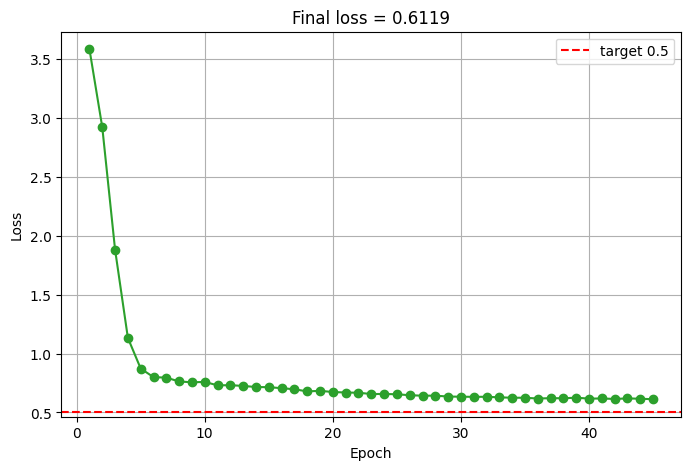

In [ ]:
# --------------------------------------------------------------
#  FULL FIXED COPY-PASTABLE SCRIPT
# --------------------------------------------------------------

import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from itertools import chain
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import av
import librosa

# ------------------- HYPERPARAMETERS -------------------
num_epochs   = 45
batch_size   = 16
max_duration = 10
sr           = 24000
base_tau     = 0.07
lam1         = 1.0
selected_pairs = data[:400]  # <-- YOUR DATA

# ------------------- DEVICE ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- FIXED PROJECTORS -------------------
class VideoProjector(nn.Module):
    def __init__(self, in_dim=768, out_dim=128, target_len=750):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)
        self.target_len = target_len
        self.log_tau = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        # x: (B, N, 768) → N = 3137, 768
        x = self.fc(x)                          # (B, N, 128)
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = self.bn(x)
        x = x.permute(0, 2, 1)                  # (B, N, 128)

        # Interpolate to exactly 750 tokens
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = F.interpolate(x, size=self.target_len, mode='linear', align_corners=False)
        x = x.permute(0, 2, 1)                  # (B, 750, 128)
        return x

class AudioProjector(nn.Module):
    def __init__(self, in_dim=750, out_dim=128):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)

    def forward(self, x):
        # x: (B, 750, T) → T ≈ 75
        x = x.mean(dim=2)                       # (B, 750) - GLOBAL average over time
        x = self.fc(x)                          # (B, 128) - ONE token per sample
        x = self.bn(x)                          # (B, 128)

        # BROADCAST to match video shape (B, 750, 128)
        x = x.unsqueeze(1).expand(-1, 750, -1)  # (B, 750, 128)
        return x

# Initialize
video_proj = VideoProjector().to(device)
audio_proj = AudioProjector().to(device)
video_proj.train()
audio_proj.train()

# ------------------- TRAINABLE PARAMS -------------------
trainable_params = [p for p in chain(
    model.parameters(),
    video_proj.parameters(),
    audio_proj.parameters()
) if p.requires_grad]

# ------------------- OPTIMIZER + SCHEDULER + AMP -------------------
optimizer = optim.AdamW(trainable_params, lr=3e-4, weight_decay=1e-5)

total_steps  = num_epochs * (len(selected_pairs) // batch_size)
warmup_steps = 3 * (len(selected_pairs) // batch_size)

def lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    prog = (step - warmup_steps) / (total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * prog))

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

# ------------------- TRAINING LOOP -------------------
losses = []
best_loss = float('inf')
patience, patience_counter = 7, 0
sim_printed = False

for epoch in range(num_epochs):
    random.shuffle(selected_pairs)
    epoch_loss = 0.0
    num_batches = len(selected_pairs) // batch_size
    print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}")

    for batch_idx in tqdm(range(num_batches), desc="Batches"):
        batch = selected_pairs[batch_idx*batch_size : (batch_idx+1)*batch_size]

        # ---------- AUDIO ----------
        wavs = []
        for item in batch:
            wav, _ = librosa.load(item["audio_path"], sr=sr, mono=True)
            target_len = sr * max_duration
            if len(wav) > target_len:
                wav = wav[:target_len]
            else:
                wav = np.pad(wav, (0, target_len - len(wav)))
            wavs.append(wav)

        audio_in = audio_processor(raw_audio=wavs, sampling_rate=sr, return_tensors="pt")
        input_vals = audio_in["input_values"].to(device)

        with torch.no_grad():
            enc = encodec.encoder(input_vals).permute(0, 2, 1)  # (B, 750, T)

        # ---------- VIDEO ----------
        videos = []
        for item in batch:
            container = av.open(item["video_path"])
            seg_len = container.streams.video[0].frames
            idx = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
            vid = read_video_pyav(container, idx)
            vid = ensure_fixed_frames(vid, 32)
            vid = center_crop_frames(vid, crop_size=224)
            videos.append(vid.astype(np.uint8))

        inputs = image_processor([[f for f in v] for v in videos],
                                 return_tensors="pt", data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # ---------- FORWARD ----------
        optimizer.zero_grad()

        if scaler:
            with torch.amp.autocast('cuda'):
                # ViViT
                out = model(**inputs)
                vid_tokens = out.last_hidden_state  # (B, 3137, 768)

                # Project to (B, 750, 128)
                vid_emb = video_proj(vid_tokens)    # (B, 750, 128)
                aud_emb = audio_proj(enc)           # (B, 750, 128)

                # L2-norm per token
                vid_emb = F.normalize(vid_emb, dim=-1)
                aud_emb = F.normalize(aud_emb, dim=-1)

                # Temperature
                tau = base_tau * video_proj.log_tau.exp().clamp(max=1.0)

                # ========== FIXED: Global average for InfoNCE ==========
                # Take MEAN over the 750 tokens → (B, 128)
                vid_global = vid_emb.mean(dim=1)    # (B, 128)
                aud_global = aud_emb.mean(dim=1)    # (B, 128)

                # Final L2 norm
                vid_global = F.normalize(vid_global, dim=1)
                aud_global = F.normalize(aud_global, dim=1)

                # CLASSIC InfoNCE: (B, B)
                logits = (aud_global @ vid_global.T) / tau  # (B, B)

                # Symmetric loss
                labels = torch.arange(batch_size, device=device)
                loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                        F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # CPU path (same logic)
            out = model(**inputs)
            vid_tokens = out.last_hidden_state
            vid_emb = video_proj(vid_tokens)
            aud_emb = audio_proj(enc)

            vid_emb = F.normalize(vid_emb, dim=-1)
            aud_emb = F.normalize(aud_emb, dim=-1)

            tau = base_tau * video_proj.log_tau.exp().clamp(max=1.0)

            vid_global = vid_emb.mean(dim=1)
            aud_global = aud_emb.mean(dim=1)
            vid_global = F.normalize(vid_global, dim=1)
            aud_global = F.normalize(aud_global, dim=1)

            logits = (aud_global @ vid_global.T) / tau

            labels = torch.arange(batch_size, device=device)
            loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                    F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2

            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
            optimizer.step()

        scheduler.step()
        epoch_loss += loss.item()

        if epoch == 0 and batch_idx == 0 and not sim_printed:
            print("\nSimilarity matrix (global average):")
            print(logits.detach().cpu().numpy().round(3))
            sim_printed = True

    # ---------- Epoch summary ----------
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    pos = torch.diag(logits).mean().item()
    neg = logits.clone().fill_diagonal_(0).mean().item()
    print(f"Pos: {pos:.3f} | Neg: {neg:.3f} | τ: {tau.item():.3f}")

    grad_norm = sum(p.grad.norm(2).item()**2 for p in trainable_params if p.grad is not None)**0.5
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f} | "
          f"GradNorm: {grad_norm:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience and avg_loss < 0.58:
            print(f"\nEarly stopping – loss {avg_loss:.4f}")
            break

# --------------------------------------------------------------
#  PLOT
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(losses)+1), losses, marker='o', color='tab:green')
plt.axhline(0.5, color='red', linestyle='--', label='target 0.5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Final loss = {losses[-1]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------
#  VIDEO → AUDIO (after training)
# --------------------------------------------------------------
def video_to_waveform(video_path, model, video_proj, encodec, image_processor, device):
    """Video → (750, 128) → Encodec decoder → waveform"""
    model.eval()
    video_proj.eval()
    with torch.no_grad():
        # Same preprocessing as training
        container = av.open(video_path)
        seg_len = container.streams.video[0].frames
        idx = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
        vid = read_video_pyav(container, idx)
        vid = ensure_fixed_frames(vid, 32)
        vid = center_crop_frames(vid, crop_size=224)

        inputs = image_processor([[f for f in vid]], return_tensors="pt",
                                 data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward
        out = model(**inputs)
        vid_tokens = out.last_hidden_state
        vid_emb = video_proj(vid_tokens)        # (1, 750, 128)
        codes = vid_emb.permute(0, 2, 1)        # (1, 128, 750)

        # Decode
        wav = encodec.decoder(codes)            # (1, 1, 240000)
        wav = wav.squeeze(0).cpu().numpy()[0]   # (240000,)
        return wav

# Example:
# wav = video_to_waveform("video.mp4", model, video_proj, encodec, image_processor, device)
# import soundfile as sf
# sf.write("generated_audio.wav", wav, sr)

In [ ]:
# --------------------------------------------------------------
#  FULL FIXED COPY-PASTABLE SCRIPT
# --------------------------------------------------------------

import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from itertools import chain
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import av
import librosa

# ------------------- HYPERPARAMETERS -------------------
num_epochs   = 45
batch_size   = 16
max_duration = 10
sr           = 24000
base_tau     = 0.07
lam1         = 1.0
selected_pairs = data[:400]  # <-- YOUR DATA

# ------------------- DEVICE ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- FIXED PROJECTORS -------------------
class VideoProjector(nn.Module):
    def __init__(self, in_dim=768, out_dim=128, target_len=750):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)
        self.target_len = target_len
        self.log_tau = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        # x: (B, N, 768) → N = 3137, 768
        x = self.fc(x)                          # (B, N, 128)
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = self.bn(x)
        x = x.permute(0, 2, 1)                  # (B, N, 128)

        # Interpolate to exactly 750 tokens
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = F.interpolate(x, size=self.target_len, mode='linear', align_corners=False)
        x = x.permute(0, 2, 1)                  # (B, 750, 128)
        return x

# class AudioProjector(nn.Module):
#     def __init__(self, in_dim=750, out_dim=128):
#         super().__init__()
#         self.fc = nn.Linear(in_dim, out_dim, bias=False)
#         self.bn = nn.BatchNorm1d(out_dim)

#     def forward(self, x):
#         # x: (B, 750, T) → T ≈ 75
#         x = x.mean(dim=2)                       # (B, 750) - GLOBAL average over time
#         x = self.fc(x)                          # (B, 128) - ONE token per sample
#         x = self.bn(x)                          # (B, 128)

#         # BROADCAST to match video shape (B, 750, 128)
#         x = x.unsqueeze(1).expand(-1, 750, -1)  # (B, 750, 128)
#         return x

# Initialize
video_proj = VideoProjector().to(device)

video_proj.train()


# ------------------- TRAINABLE PARAMS -------------------
trainable_params = [p for p in chain(
    model.parameters(),
    video_proj.parameters()
) if p.requires_grad]

# ------------------- OPTIMIZER + SCHEDULER + AMP -------------------
optimizer = optim.AdamW(trainable_params, lr=3e-4, weight_decay=1e-5)

total_steps  = num_epochs * (len(selected_pairs) // batch_size)
warmup_steps = 3 * (len(selected_pairs) // batch_size)

def lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    prog = (step - warmup_steps) / (total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * prog))

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

# ------------------- TRAINING LOOP -------------------
losses = []
best_loss = float('inf')
patience, patience_counter = 7, 0
sim_printed = False

for epoch in range(num_epochs):
    random.shuffle(selected_pairs)
    epoch_loss = 0.0
    num_batches = len(selected_pairs) // batch_size
    print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}")

    for batch_idx in tqdm(range(num_batches), desc="Batches"):
        batch = selected_pairs[batch_idx*batch_size : (batch_idx+1)*batch_size]

        # ---------- AUDIO ----------
        wavs = []
        for item in batch:
            wav, _ = librosa.load(item["audio_path"], sr=sr, mono=True)
            target_len = sr * max_duration
            if len(wav) > target_len:
                wav = wav[:target_len]
            else:
                wav = np.pad(wav, (0, target_len - len(wav)))
            wavs.append(wav)

        audio_in = audio_processor(raw_audio=wavs, sampling_rate=sr, return_tensors="pt")
        input_vals = audio_in["input_values"].to(device)

        with torch.no_grad():
            enc = encodec.encoder(input_vals).permute(0, 2, 1)  # (B, 750, T)

        # ---------- VIDEO ----------
        videos = []
        for item in batch:
            container = av.open(item["video_path"])
            seg_len = container.streams.video[0].frames
            idx = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
            vid = read_video_pyav(container, idx)
            vid = ensure_fixed_frames(vid, 32)
            vid = center_crop_frames(vid, crop_size=224)
            videos.append(vid.astype(np.uint8))

        inputs = image_processor([[f for f in v] for v in videos],
                                 return_tensors="pt", data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # ---------- FORWARD ----------
        optimizer.zero_grad()

        if scaler:
            with torch.amp.autocast('cuda'):
                # ViViT
                out = model(**inputs)
                vid_tokens = out.last_hidden_state  # (B, 3137, 768)

                # Project to (B, 750, 128)
                vid_emb = video_proj(vid_tokens)    # (B, 750, 128)
                aud_emb = enc# (B, 750, 128)

                # L2-norm per token
                vid_emb = F.normalize(vid_emb, dim=-1)
                aud_emb = F.normalize(aud_emb, dim=-1)

                # Temperature
                tau = base_tau * video_proj.log_tau.exp().clamp(max=1.0)

                # ========== FIXED: Global average for InfoNCE ==========
                # Take MEAN over the 750 tokens → (B, 128)
                vid_global = vid_emb.mean(dim=1)    # (B, 128)
                aud_global = aud_emb.mean(dim=1)    # (B, 128)

                # Final L2 norm
                vid_global = F.normalize(vid_global, dim=1)
                aud_global = F.normalize(aud_global, dim=1)

                # CLASSIC InfoNCE: (B, B)
                logits = (aud_global @ vid_global.T) / tau  # (B, B)

                # Symmetric loss
                labels = torch.arange(batch_size, device=device)
                loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                        F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # CPU path (same logic)
            out = model(**inputs)
            vid_tokens = out.last_hidden_state
            vid_emb = video_proj(vid_tokens)
            aud_emb = enc

            vid_emb = F.normalize(vid_emb, dim=-1)
            aud_emb = F.normalize(aud_emb, dim=-1)

            tau = base_tau * video_proj.log_tau.exp().clamp(max=1.0)

            vid_global = vid_emb.mean(dim=1)
            aud_global = aud_emb.mean(dim=1)
            vid_global = F.normalize(vid_global, dim=1)
            aud_global = F.normalize(aud_global, dim=1)

            logits = (aud_global @ vid_global.T) / tau

            labels = torch.arange(batch_size, device=device)
            loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                    F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2

            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
            optimizer.step()

        scheduler.step()
        epoch_loss += loss.item()

        if epoch == 0 and batch_idx == 0 and not sim_printed:
            print("\nSimilarity matrix (global average):")
            print(logits.detach().cpu().numpy().round(3))
            sim_printed = True

    # ---------- Epoch summary ----------
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    pos = torch.diag(logits).mean().item()
    neg = logits.clone().fill_diagonal_(0).mean().item()
    print(f"Pos: {pos:.3f} | Neg: {neg:.3f} | τ: {tau.item():.3f}")

    grad_norm = sum(p.grad.norm(2).item()**2 for p in trainable_params if p.grad is not None)**0.5
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f} | "
          f"GradNorm: {grad_norm:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience and avg_loss < 0.58:
            print(f"\nEarly stopping – loss {avg_loss:.4f}")
            break

# --------------------------------------------------------------
#  PLOT
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(losses)+1), losses, marker='o', color='tab:green')
plt.axhline(0.5, color='red', linestyle='--', label='target 0.5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Final loss = {losses[-1]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------
#  VIDEO → AUDIO (after training)
# --------------------------------------------------------------
def video_to_waveform(video_path, model, video_proj, encodec, image_processor, device):
    """Video → (750, 128) → Encodec decoder → waveform"""
    model.eval()
    video_proj.eval()
    with torch.no_grad():
        # Same preprocessing as training
        container = av.open(video_path)
        seg_len = container.streams.video[0].frames
        idx = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
        vid = read_video_pyav(container, idx)
        vid = ensure_fixed_frames(vid, 32)
        vid = center_crop_frames(vid, crop_size=224)

        inputs = image_processor([[f for f in vid]], return_tensors="pt",
                                 data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward
        out = model(**inputs)
        vid_tokens = out.last_hidden_state
        vid_emb = video_proj(vid_tokens)        # (1, 750, 128)
        codes = vid_emb.permute(0, 2, 1)        # (1, 128, 750)

        # Decode
        wav = encodec.decoder(codes)            # (1, 1, 240000)
        wav = wav.squeeze(0).cpu().numpy()[0]   # (240000,)
        return wav

# Example:
# wav = video_to_waveform("video.mp4", model, video_proj, encodec, image_processor, device)
# import soundfile as sf
# sf.write("generated_audio.wav", wav, sr)

Using device: cuda

==================== Epoch 1/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `VivitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Similarity matrix (global average):
[[ 0.312  0.14  -0.165  0.694 -0.719 -0.876  0.462  0.249  1.361 -1.354
  -0.09   0.582 -1.401  1.012 -0.654 -0.089]
 [ 0.338  0.234 -0.035  0.701 -0.986 -0.74   0.58   0.324  1.489 -1.576
   0.133  0.623 -1.217  0.848 -0.918 -0.261]
 [ 0.298  0.102 -0.208  0.682 -0.628 -0.922  0.401  0.222  1.314 -1.27
  -0.156  0.588 -1.472  1.071 -0.552 -0.025]
 [ 0.329  0.182 -0.107  0.684 -0.844 -0.81   0.507  0.291  1.42  -1.462
   0.013  0.606 -1.327  0.942 -0.773 -0.157]
 [ 0.294  0.089 -0.221  0.677 -0.603 -0.921  0.397  0.227  1.315 -1.27
  -0.169  0.58  -1.468  1.082 -0.55  -0.02 ]
 [ 0.314  0.146 -0.152  0.694 -0.748 -0.868  0.467  0.255  1.374 -1.384
  -0.064  0.611 -1.386  1.    -0.678 -0.105]
 [ 0.322  0.168 -0.122  0.696 -0.796 -0.835  0.488  0.277  1.406 -1.433
  -0.022  0.609 -1.349  0.956 -0.737 -0.141]
 [ 0.322  0.14  -0.146  0.688 -0.744 -0.862  0.47   0.26   1.386 -1.392
  -0.064  0.588 -1.386  1.001 -0.686 -0.104]
 [ 0.338  0.181 -0.107  0.688

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 0.069 | Neg: 0.024 | τ: 0.070
Epoch 2/45 | Loss: 2.864043 | GradNorm: 1.000 | LR: 2.00e-04

==================== Epoch 3/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 0.022 | Neg: 0.005 | τ: 0.070
Epoch 3/45 | Loss: 2.822725 | GradNorm: 1.000 | LR: 3.00e-04

==================== Epoch 4/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 0.013 | Neg: -0.004 | τ: 0.070
Epoch 4/45 | Loss: 2.800089 | GradNorm: 1.000 | LR: 3.00e-04

==================== Epoch 5/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from itertools import chain
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import av
import librosa

# ------------------- HYPERPARAMETERS -------------------
num_epochs   = 45
batch_size   = 16
max_duration = 10
sr           = 24000
base_tau     = 0.07
lam1         = 1.0
selected_pairs = data[:400]  # <-- YOUR DATA

# ------------------- DEVICE ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- FIXED PROJECTORS -------------------
class VideoProjector(nn.Module):
    def __init__(self, in_dim=768, out_dim=128, target_len=750):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)
        self.target_len = target_len
        self.log_tau = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        # x: (B, N, 768) → N = 3137
        x = self.fc(x)                          # (B, N, 128)
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = self.bn(x)
        x = x.permute(0, 2, 1)                  # (B, N, 128)

        # Interpolate to exactly 750 tokens
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = F.interpolate(x, size=self.target_len, mode='linear', align_corners=False)
        x = x.permute(0, 2, 1)                  # (B, 750, 128)
        return x

class AudioProjector(nn.Module):
    def __init__(self, in_dim=750, out_dim=128):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)

    def forward(self, x):
        # x: (B, 750, T) → T ≈ 75
        x = x.mean(dim=2)                       # (B, 750) - GLOBAL average over time
        x = self.fc(x)                          # (B, 128) - ONE token per sample
        x = self.bn(x)                          # (B, 128)

        # BROADCAST to match video shape (B, 750, 128)
        x = x.unsqueeze(1).expand(-1, 750, -1)  # (B, 750, 128)
        return x

# Initialize
video_proj = VideoProjector().to(device)
audio_proj = AudioProjector().to(device)


Using device: cuda


In [ ]:
def video_to_waveform(video_path, model, video_proj, encodec, image_processor, device):
    """Video → (750, 128) → Encodec decoder → waveform"""
    model.eval()
    video_proj.eval()
    with torch.no_grad():
        # Same preprocessing as training
        container = av.open(video_path)
        seg_len = container.streams.video[0].frames
        idx = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
        vid = read_video_pyav(container, idx)
        vid = ensure_fixed_frames(vid, 32)
        vid = center_crop_frames(vid, crop_size=224)

        inputs = image_processor([[f for f in vid]], return_tensors="pt",
                                 data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward
        out = model(**inputs)
        vid_tokens = out.last_hidden_state
        vid_emb = video_proj(vid_tokens)        # (1, 750, 128)
        codes = vid_emb.permute(0, 2, 1)        # (1, 128, 750)

        # Decode
        # wav = encodec.decoder(codes)            # (1, 1, 240000)
        # wav = wav.squeeze(0).cpu().numpy()[0]   # (240000,)
        return codes

In [ ]:
# Example:
codes = video_to_waveform("/content/drive/MyDrive/IE_643_Project/train_clips_raw_videos/1YAa5_d-zg0_10-8-rgb_front.mp4", model, video_proj, encodec, image_processor, device)
# import soundfile as sf
# sf.write("generated_audio.wav", wav, sr)

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `VivitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


In [ ]:
codes

tensor([[[-0.2047, -0.4161, -0.4226,  ..., -0.3920, -0.5322, -0.4651],
         [ 0.6640,  0.6553,  0.4579,  ...,  0.5780,  0.0364,  0.1180],
         [-0.2236, -0.1989, -0.4936,  ..., -0.3392, -0.4911, -0.4532],
         ...,
         [ 0.0418, -0.0901,  0.7229,  ...,  0.5653,  0.4114,  0.2313],
         [ 0.2016,  0.4075,  0.5274,  ..., -0.2974, -0.1905, -0.3265],
         [ 0.7453,  0.7847,  0.4214,  ...,  1.0594,  0.9207,  1.0843]]],
       device='cuda:0')

In [ ]:
x=encodec.quantizer.encode(codes, bandwidth=1.5)
x = x.permute(1, 0, 2)
x = x.unsqueeze(0)
x.shape


tensor([[[[110, 110, 110,  ..., 110, 110, 110],
          [894, 894, 302,  ..., 519, 924, 894]]]], device='cuda:0')

In [ ]:
import soundfile as sf
with torch.no_grad():
    decoded = encodec.decode(x,audio_scales=[None])

# -------------------------------
# Extract and save reconstructed audio
# -------------------------------
if isinstance(decoded, (tuple, list)):
    audio = decoded[0].squeeze().cpu().numpy()

else:
    audio = decoded.audio_values.squeeze().cpu().numpy()
    # print("Decoded audio shape:", audio.shape)

# Ensure audio is mono float32
if audio.ndim > 1:
    audio = audio[0]
audio = audio.astype(np.float32)

# Write file
sf.write('test_reconstructed.wav', audio, samplerate=24000)
print("✅ Wrote test_reconstructed.wav — play to verify.")
# embeddings = encodec.quantizer.decode(encoder_outputs.audio_codes.squeeze(0))
# print(embeddings)

✅ Wrote test_reconstructed.wav — play to verify.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models will be saved to: /content/drive/MyDrive/IE_643_Project
Using device: cuda

==================== Epoch 1/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_utils.py:51: UserWarning: The following named arguments are not valid for `VivitImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)



Similarity matrix (global average):
[[ 6.230e-01 -2.280e-01 -1.173e+00 -5.078e-01  6.558e-01 -1.027e+00
   1.010e+00 -1.348e+00 -2.391e+00  1.260e-01 -1.150e-01  1.883e+00
   2.759e-01  1.386e+00  1.341e+00 -2.891e-01]
 [-1.190e-01  1.664e+00 -4.441e-01 -1.314e+00 -1.541e+00  4.771e-01
  -1.915e+00  2.461e+00  9.839e-01 -1.091e+00  9.780e-01  1.601e-02
   1.708e+00 -1.100e-01 -1.809e+00 -3.840e-01]
 [ 4.460e-01  1.706e+00  1.172e+00 -1.735e+00 -2.658e+00 -8.369e-01
   1.136e+00 -9.003e-03 -1.899e-01  1.669e+00  7.349e-01 -2.693e+00
  -6.598e-02 -6.598e-02  5.220e-01  2.520e-01]
 [-2.207e+00  1.747e+00  2.520e+00  1.969e+00 -1.980e-01  1.440e-01
   2.820e-01 -4.901e-02 -1.321e+00  8.032e-01  1.351e+00 -1.969e+00
  -1.679e+00 -8.799e-01  2.729e-01 -3.291e-01]
 [ 3.130e-01 -4.199e-02 -6.519e-01 -4.160e-01 -7.612e-01 -9.399e-01
   3.940e-01 -3.311e-01 -1.149e+00  3.831e-01  6.138e-01  2.203e+00
  -7.642e-01 -4.002e-03  6.992e-01  3.130e-01]
 [ 1.081e+00 -1.689e+00  5.879e-01 -7.041e-01 -5

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 0.891 | Neg: -0.055 | τ: 0.070
Epoch 2/45 | Loss: 2.847476 | GradNorm: 1.000 | LR: 2.00e-04

==================== Epoch 3/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 1.792 | Neg: -0.114 | τ: 0.070
Epoch 3/45 | Loss: 1.896043 | GradNorm: 1.000 | LR: 3.00e-04

==================== Epoch 4/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 3.436 | Neg: -0.214 | τ: 0.070
Epoch 4/45 | Loss: 1.133133 | GradNorm: 1.000 | LR: 3.00e-04

==================== Epoch 5/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 3.996 | Neg: -0.250 | τ: 0.070
Epoch 5/45 | Loss: 0.851182 | GradNorm: 1.000 | LR: 2.98e-04

==================== Epoch 6/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.965 | Neg: -0.309 | τ: 0.070
Epoch 6/45 | Loss: 0.800490 | GradNorm: 1.000 | LR: 2.96e-04

==================== Epoch 7/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.754 | Neg: -0.296 | τ: 0.070
Epoch 7/45 | Loss: 0.773331 | GradNorm: 1.000 | LR: 2.93e-04

==================== Epoch 8/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.719 | Neg: -0.354 | τ: 0.070
Epoch 8/45 | Loss: 0.781753 | GradNorm: 1.000 | LR: 2.90e-04

==================== Epoch 9/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.859 | Neg: -0.298 | τ: 0.070
Epoch 9/45 | Loss: 0.765817 | GradNorm: 1.000 | LR: 2.85e-04

==================== Epoch 10/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.168 | Neg: -0.327 | τ: 0.070
Epoch 10/45 | Loss: 0.751872 | GradNorm: 1.000 | LR: 2.80e-04

==================== Epoch 11/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.926 | Neg: -0.309 | τ: 0.070
Epoch 11/45 | Loss: 0.763353 | GradNorm: 1.000 | LR: 2.74e-04

==================== Epoch 12/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.266 | Neg: -0.331 | τ: 0.070
Epoch 12/45 | Loss: 0.742807 | GradNorm: 1.000 | LR: 2.67e-04

==================== Epoch 13/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.582 | Neg: -0.344 | τ: 0.070
Epoch 13/45 | Loss: 0.720164 | GradNorm: 1.000 | LR: 2.60e-04

==================== Epoch 14/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 6.078 | Neg: -0.377 | τ: 0.070
Epoch 14/45 | Loss: 0.728886 | GradNorm: 1.000 | LR: 2.52e-04

==================== Epoch 15/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.199 | Neg: -0.324 | τ: 0.070
Epoch 15/45 | Loss: 0.717122 | GradNorm: 1.000 | LR: 2.44e-04

==================== Epoch 16/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.113 | Neg: -0.322 | τ: 0.070
Epoch 16/45 | Loss: 0.700353 | GradNorm: 1.000 | LR: 2.34e-04

==================== Epoch 17/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.535 | Neg: -0.352 | τ: 0.070
Epoch 17/45 | Loss: 0.691974 | GradNorm: 1.000 | LR: 2.25e-04

==================== Epoch 18/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.363 | Neg: -0.335 | τ: 0.070
Epoch 18/45 | Loss: 0.697204 | GradNorm: 1.000 | LR: 2.15e-04

==================== Epoch 19/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.441 | Neg: -0.339 | τ: 0.070
Epoch 19/45 | Loss: 0.690638 | GradNorm: 1.000 | LR: 2.05e-04

==================== Epoch 20/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.531 | Neg: -0.335 | τ: 0.070
Epoch 20/45 | Loss: 0.674893 | GradNorm: 1.000 | LR: 1.94e-04

==================== Epoch 21/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.359 | Neg: -0.335 | τ: 0.070
Epoch 21/45 | Loss: 0.672176 | GradNorm: 1.000 | LR: 1.83e-04

==================== Epoch 22/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.504 | Neg: -0.342 | τ: 0.070
Epoch 22/45 | Loss: 0.659258 | GradNorm: 1.000 | LR: 1.72e-04

==================== Epoch 23/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.117 | Neg: -0.321 | τ: 0.070
Epoch 23/45 | Loss: 0.655083 | GradNorm: 1.000 | LR: 1.61e-04

==================== Epoch 24/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.070 | Neg: -0.318 | τ: 0.070
Epoch 24/45 | Loss: 0.660726 | GradNorm: 1.000 | LR: 1.50e-04

==================== Epoch 25/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.488 | Neg: -0.344 | τ: 0.070
Epoch 25/45 | Loss: 0.648617 | GradNorm: 1.000 | LR: 1.39e-04

==================== Epoch 26/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.062 | Neg: -0.318 | τ: 0.070
Epoch 26/45 | Loss: 0.647045 | GradNorm: 1.000 | LR: 1.28e-04

==================== Epoch 27/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.211 | Neg: -0.325 | τ: 0.070
Epoch 27/45 | Loss: 0.643662 | GradNorm: 1.000 | LR: 1.17e-04

==================== Epoch 28/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.727 | Neg: -0.293 | τ: 0.070
Epoch 28/45 | Loss: 0.636265 | GradNorm: 1.000 | LR: 1.06e-04

==================== Epoch 29/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.930 | Neg: -0.309 | τ: 0.070
Epoch 29/45 | Loss: 0.635072 | GradNorm: 1.000 | LR: 9.52e-05

==================== Epoch 30/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.805 | Neg: -0.302 | τ: 0.070
Epoch 30/45 | Loss: 0.629095 | GradNorm: 1.000 | LR: 8.49e-05

==================== Epoch 31/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.223 | Neg: -0.321 | τ: 0.070
Epoch 31/45 | Loss: 0.625833 | GradNorm: 0.704 | LR: 7.50e-05

==================== Epoch 32/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.023 | Neg: -0.313 | τ: 0.070
Epoch 32/45 | Loss: 0.624239 | GradNorm: 0.670 | LR: 6.55e-05

==================== Epoch 33/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.176 | Neg: -0.317 | τ: 0.070
Epoch 33/45 | Loss: 0.623141 | GradNorm: 1.000 | LR: 5.65e-05

==================== Epoch 34/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.844 | Neg: -0.303 | τ: 0.070
Epoch 34/45 | Loss: 0.630252 | GradNorm: 1.000 | LR: 4.80e-05

==================== Epoch 35/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.805 | Neg: -0.297 | τ: 0.070
Epoch 35/45 | Loss: 0.623401 | GradNorm: 1.000 | LR: 4.00e-05

==================== Epoch 36/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.195 | Neg: -0.322 | τ: 0.070
Epoch 36/45 | Loss: 0.615796 | GradNorm: 0.753 | LR: 3.27e-05

==================== Epoch 37/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.059 | Neg: -0.314 | τ: 0.070
Epoch 37/45 | Loss: 0.615891 | GradNorm: 0.670 | LR: 2.61e-05

==================== Epoch 38/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.980 | Neg: -0.312 | τ: 0.070
Epoch 38/45 | Loss: 0.617677 | GradNorm: 1.000 | LR: 2.01e-05

==================== Epoch 39/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.797 | Neg: -0.296 | τ: 0.070
Epoch 39/45 | Loss: 0.617221 | GradNorm: 1.000 | LR: 1.49e-05

==================== Epoch 40/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.043 | Neg: -0.315 | τ: 0.070
Epoch 40/45 | Loss: 0.614542 | GradNorm: 1.000 | LR: 1.04e-05

==================== Epoch 41/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.086 | Neg: -0.320 | τ: 0.070
Epoch 41/45 | Loss: 0.618900 | GradNorm: 0.770 | LR: 6.66e-06

==================== Epoch 42/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.102 | Neg: -0.316 | τ: 0.070
Epoch 42/45 | Loss: 0.614416 | GradNorm: 0.972 | LR: 3.76e-06

==================== Epoch 43/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.773 | Neg: -0.295 | τ: 0.070
Epoch 43/45 | Loss: 0.614988 | GradNorm: 1.000 | LR: 1.68e-06

==================== Epoch 44/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 5.121 | Neg: -0.315 | τ: 0.070
Epoch 44/45 | Loss: 0.616698 | GradNorm: 0.570 | LR: 4.19e-07

==================== Epoch 45/45 ====================


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Pos: 4.789 | Neg: -0.295 | τ: 0.070
Epoch 45/45 | Loss: 0.616025 | GradNorm: 0.996 | LR: 0.00e+00

Training complete! Final model saved to:
/content/drive/MyDrive/IE_643_Project/vivit_final_weights.pth


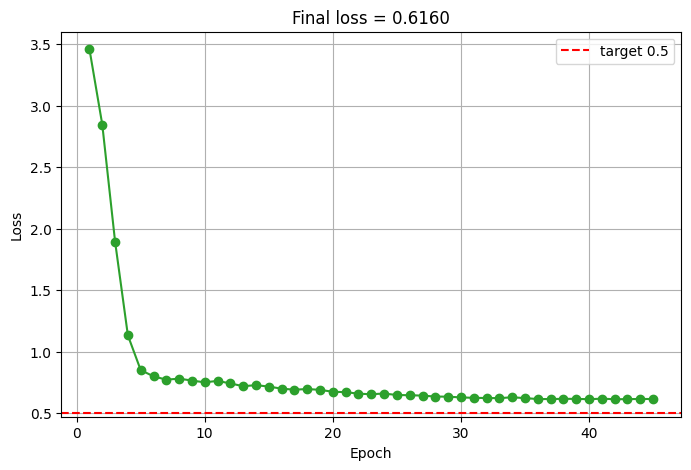

In [ ]:
# --------------------------------------------------------------
#  FULL FIXED COPY-PASTABLE SCRIPT WITH MODEL SAVING
# --------------------------------------------------------------

import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from itertools import chain
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import av
import librosa
import os
from google.colab import drive

# ------------------- MOUNT GOOGLE DRIVE -------------------
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/IE_643_Project"
os.makedirs(save_dir, exist_ok=True)
print(f"Models will be saved to: {save_dir}")

# ------------------- HYPERPARAMETERS -------------------
num_epochs   = 45
batch_size   = 16
max_duration = 10
sr           = 24000
base_tau     = 0.07
lam1         = 1.0
selected_pairs = data[:400]  # <-- YOUR DATA

# ------------------- DEVICE ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- FIXED PROJECTORS -------------------
class VideoProjector(nn.Module):
    def __init__(self, in_dim=768, out_dim=128, target_len=750):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)
        self.target_len = target_len
        self.log_tau = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        # x: (B, N, 768) → N = 3137
        x = self.fc(x)                          # (B, N, 128)
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = self.bn(x)
        x = x.permute(0, 2, 1)                  # (B, N, 128)

        # Interpolate to exactly 750 tokens
        x = x.permute(0, 2, 1)                  # (B, 128, N)
        x = F.interpolate(x, size=self.target_len, mode='linear', align_corners=False)
        x = x.permute(0, 2, 1)                  # (B, 750, 128)
        return x

class AudioProjector(nn.Module):
    def __init__(self, in_dim=750, out_dim=128):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)

    def forward(self, x):
        # x: (B, 750, T) → T ≈ 75
        x = x.mean(dim=2)                       # (B, 750) - GLOBAL average over time
        x = self.fc(x)                          # (B, 128) - ONE token per sample
        x = self.bn(x)                          # (B, 128)

        # BROADCAST to match video shape (B, 750, 128)
        x = x.unsqueeze(1).expand(-1, 750, -1)  # (B, 750, 128)
        return x

# Initialize
video_proj = VideoProjector().to(device)
audio_proj = AudioProjector().to(device)
video_proj.train()
audio_proj.train()

# ------------------- TRAINABLE PARAMS -------------------
trainable_params = [p for p in chain(
    model.parameters(),
    video_proj.parameters(),
    audio_proj.parameters()
) if p.requires_grad]

# ------------------- OPTIMIZER + SCHEDULER + AMP -------------------
optimizer = optim.AdamW(trainable_params, lr=3e-4, weight_decay=1e-5)

total_steps  = num_epochs * (len(selected_pairs) // batch_size)
warmup_steps = 3 * (len(selected_pairs) // batch_size)

def lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    prog = (step - warmup_steps) / (total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * prog))

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

# ------------------- TRAINING LOOP -------------------
losses = []
best_loss = float('inf')
patience, patience_counter = 7, 0
sim_printed = False

for epoch in range(num_epochs):
    random.shuffle(selected_pairs)
    epoch_loss = 0.0
    num_batches = len(selected_pairs) // batch_size
    print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}")

    for batch_idx in tqdm(range(num_batches), desc="Batches"):
        batch = selected_pairs[batch_idx*batch_size : (batch_idx+1)*batch_size]

        # ---------- AUDIO ----------
        wavs = []
        for item in batch:
            wav, _ = librosa.load(item["audio_path"], sr=sr, mono=True)
            target_len = sr * max_duration
            if len(wav) > target_len:
                wav = wav[:target_len]
            else:
                wav = np.pad(wav, (0, target_len - len(wav)))
            wavs.append(wav)

        audio_in = audio_processor(raw_audio=wavs, sampling_rate=sr, return_tensors="pt")
        input_vals = audio_in["input_values"].to(device)

        with torch.no_grad():
            enc = encodec.encoder(input_vals).permute(0, 2, 1)  # (B, 750, T)

        # ---------- VIDEO ----------
        videos = []
        for item in batch:
            container = av.open(item["video_path"])
            seg_len = container.streams.video[0].frames
            idx = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
            vid = read_video_pyav(container, idx)
            vid = ensure_fixed_frames(vid, 32)
            vid = center_crop_frames(vid, crop_size=224)
            videos.append(vid.astype(np.uint8))

        inputs = image_processor([[f for f in v] for v in videos],
                                 return_tensors="pt", data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # ---------- FORWARD ----------
        optimizer.zero_grad()

        if scaler:
            with torch.amp.autocast('cuda'):
                # ViViT
                out = model(**inputs)
                vid_tokens = out.last_hidden_state  # (B, 3137, 768)

                # Project to (B, 750, 128)
                vid_emb = video_proj(vid_tokens)    # (B, 750, 128)
                aud_emb = audio_proj(enc)           # (B, 750, 128)

                # L2-norm per token
                vid_emb = F.normalize(vid_emb, dim=-1)
                aud_emb = F.normalize(aud_emb, dim=-1)

                # Temperature
                tau = base_tau * video_proj.log_tau.exp().clamp(max=1.0)

                # ========== Global average for InfoNCE ==========
                vid_global = vid_emb.mean(dim=1)    # (B, 128)
                aud_global = aud_emb.mean(dim=1)    # (B, 128)

                vid_global = F.normalize(vid_global, dim=1)
                aud_global = F.normalize(aud_global, dim=1)

                logits = (aud_global @ vid_global.T) / tau  # (B, B)

                labels = torch.arange(batch_size, device=device)
                loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                        F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(**inputs)
            vid_tokens = out.last_hidden_state
            vid_emb = video_proj(vid_tokens)
            aud_emb = audio_proj(enc)

            vid_emb = F.normalize(vid_emb, dim=-1)
            aud_emb = F.normalize(aud_emb, dim=-1)

            tau = base_tau * video_proj.log_tau.exp().clamp(max=1.0)

            vid_global = vid_emb.mean(dim=1)
            aud_global = aud_emb.mean(dim=1)
            vid_global = F.normalize(vid_global, dim=1)
            aud_global = F.normalize(aud_global, dim=1)

            logits = (aud_global @ vid_global.T) / tau

            labels = torch.arange(batch_size, device=device)
            loss = (F.cross_entropy(logits, labels, label_smoothing=0.1) +
                    F.cross_entropy(logits.T, labels, label_smoothing=0.1)) / 2

            loss.backward()
            torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
            optimizer.step()

        scheduler.step()
        epoch_loss += loss.item()

        if epoch == 0 and batch_idx == 0 and not sim_printed:
            print("\nSimilarity matrix (global average):")
            print(logits.detach().cpu().numpy().round(3))
            sim_printed = True

    # ---------- Epoch summary ----------
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)

    pos = torch.diag(logits).mean().item()
    neg = logits.clone().fill_diagonal_(0).mean().item()
    print(f"Pos: {pos:.3f} | Neg: {neg:.3f} | τ: {tau.item():.3f}")

    grad_norm = sum(p.grad.norm(2).item()**2 for p in trainable_params if p.grad is not None)**0.5
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f} | "
          f"GradNorm: {grad_norm:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience and avg_loss < 0.58:
            print(f"\nEarly stopping – loss {avg_loss:.4f}")
            break

# --------------------------------------------------------------
#  SAVE FINAL MODEL WEIGHTS
# --------------------------------------------------------------
final_save_path = os.path.join(save_dir, "vivit_final_weights.pth")
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'video_proj_state_dict': video_proj.state_dict(),
    'audio_proj_state_dict': audio_proj.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
    'tau': video_proj.log_tau.exp().item() * base_tau,
}, final_save_path)

print(f"\nTraining complete! Final model saved to:\n{final_save_path}")

# --------------------------------------------------------------
#  PLOT
# --------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(losses)+1), losses, marker='o', color='tab:green')
plt.axhline(0.5, color='red', linestyle='--', label='target 0.5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Final loss = {losses[-1]:.4f}')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------
#  VIDEO → AUDIO (after training)
# --------------------------------------------------------------
def video_to_waveform(video_path, model, video_proj, encodec, image_processor, device):
    """Video → (750, 128) → Encodec decoder → waveform"""
    model.eval()
    video_proj.eval()
    with torch.no_grad():
        container = av.open(video_path)
        seg_len = container.streams.video[0].frames
        idx = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=seg_len)
        vid = read_video_pyav(container, idx)
        vid = ensure_fixed_frames(vid, 32)
        vid = center_crop_frames(vid, crop_size=224)

        inputs = image_processor([[f for f in vid]], return_tensors="pt",
                                 data_format="channels_first", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        out = model(**inputs)
        vid_tokens = out.last_hidden_state
        vid_emb = video_proj(vid_tokens)        # (1, 750, 128)
        codes = vid_emb.permute(0, 2, 1)        # (1, 128, 750)

        # wav = encodec.decoder(codes)            # (1, 1, 240000)
        # wav = wav.squeeze(0).cpu().numpy()[0]   # (240000,)
        return codes

# Example usage:
# wav = video_to_waveform("video.mp4", model, video_proj, encodec, image_processor, device)
# import soundfile as sf
# sf.write("generated_audio.wav", wav, sr)